In [2]:
import warnings
from typing import NamedTuple, Optional, TypedDict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import load_data
from utils.constants import EWM_ALPHA, NAN_THRESHOLD, Events, datetimes
from utils.plots import plot

warnings.filterwarnings("ignore")

In [3]:
class StationsToChoose(TypedDict):
    """
    Structure for station selection data.

    Attributes:
        stations: list[str]. Available station names for random sampling.
        num_sample: int. Number of stations to sample from the available list.
    """

    stations: list[str]
    num_sample: int


EVENT: Events = "Forbush Decrease"
MAX_SAMPLES: int = 10  # Samples per date
REPETITION: bool = False  # If True, it will repeat stations already calculated
EWM: bool = True  # If True, it will calculate EWM metrics


EVENT_DATE = "2024-03-24"  # Just one event date for testing
event_replace: str = EVENT.replace(" ", "")

In [4]:
class OnsetResult(NamedTuple):
    onset: Optional[pd.Timestamp]
    df: pd.DataFrame
    threshold_value: float
    groups: list[tuple[pd.Timestamp, pd.Timestamp, int]]
    min_approx_onset_datetime: pd.Timestamp
    max_approx_onset_datetime: pd.Timestamp

In [5]:
def get_valid_stations(
    df: pd.DataFrame, threshold: Optional[float] = None
) -> list[str]:
    """
    Drop stations (columns) that have a high ratio of NaN values.
    The DataFrame is the one with the data of the stations (all.txt).

    Args:
        df (pd.DataFrame): DataFrame with the stations data.
        threshold (Optional[float]): Ratio of NaN values to consider a station invalid.
            If None, it will use the global NAN_THRESHOLD.

    Returns:
        list[str]: List of valid station names (columns).
    """
    if threshold is None:
        threshold = NAN_THRESHOLD

    nans_count = dict(
        filter(
            lambda x: x[1] > 0,
            df.reset_index().drop(columns="datetime").isna().sum().to_dict().items(),
        )
    )

    total = len(df)

    # Drop columns (stations) that exceed a nan ratio threshold
    stations = list(
        df.drop(
            columns=list(
                filter(
                    lambda station: nans_count[station] / total >= threshold,
                    nans_count,
                )
            )
        ).columns[1:]
    )

    return stations

In [6]:
suffix = f"ewm_alpha_{EWM_ALPHA}" if EWM_ALPHA and EWM else ""


def prepare_df(path: str) -> pd.DataFrame:
    df = load_data(path).set_index("datetime")
    return df.ewm(alpha=EWM_ALPHA).mean() if EWM_ALPHA and EWM else df


raw_df = prepare_df(f"./data/{event_replace}/{EVENT_DATE}/all.2-days.txt")
valid_stations = get_valid_stations(
    raw_df,
    threshold=NAN_THRESHOLD,
)

## Just one station for testing

In [17]:
# Here's the implementation based on:
# Forbush Decreases during strong Geomagnetic Storms: TimeDelays, Rigidity Effects, and ICME-Driven Modulation
def get_approx_onset(
    raw_event: pd.Series,
    max_approx_onset: str,
    k: float = 2.0,
    n_threshold: int = 7,
    delta_minutes: int = 60 * 24,  # 1 day
    *,
    debug: bool = False,
    return_filtered_groups: bool = False,
) -> pd.Timestamp | OnsetResult:
    max_approx_onset_datetime = pd.to_datetime(max_approx_onset)
    min_approx_onset_datetime = max_approx_onset_datetime - pd.Timedelta(
        minutes=delta_minutes
    )

    raw_event_filtered = raw_event.loc[
        min_approx_onset_datetime:max_approx_onset_datetime
    ].copy()

    media = raw_event_filtered.mean()
    std = raw_event_filtered.std()
    threshold_value = media - k * std

    df = pd.DataFrame(raw_event_filtered).reset_index()
    df.columns = ["datetime", "value"]
    df["condition"] = df["value"] <= threshold_value

    # Get groups of consecutive True values
    # maybe there's a better way to do this with pandas, but this works for now
    groups = []
    counter = 0
    for i, row in df.iterrows():
        if not row.condition:
            counter = 0
            continue

        counter += 1
        if counter == 1:
            start_time = row["datetime"]

        try:
            next_time = i + 1
        except KeyError:
            next_time = i

        if counter >= 1 and (
            i == df.index[-1] or not df.loc[next_time, "condition"]
        ):
            end_time = row["datetime"]
            groups.append((start_time, end_time, counter))

    filtered_groups = list(filter(lambda x: x[2] >= n_threshold, groups))
    if not filtered_groups:
        print(f"No groups found with the given `n_threshold` ({n_threshold}).")
        return_groups = groups if return_filtered_groups else []
        return (
            None
            if not debug
            else (
                None,
                df,
                threshold_value,
                return_groups,
                min_approx_onset_datetime,
                max_approx_onset_datetime,
            )
        )

    # Based on the paper, the onset block is the first one
    onset_block = filtered_groups[0] if filtered_groups else None
    onset = onset_block[0] if onset_block else None

    if debug:
        return_groups = filtered_groups if return_filtered_groups else groups
        return (
            onset,
            df,
            threshold_value,
            return_groups,
            min_approx_onset_datetime,
            max_approx_onset_datetime,
        )

    return onset


In [18]:
def plot_onset_analysis(
    raw_event: pd.Series,
    tmp_df: pd.DataFrame,
    threshold_value: float,
    groups: list[tuple[pd.Timestamp, pd.Timestamp, int]],
    onset: pd.Timestamp,
    real_onset: str,
    min_approx_onset_datetime: pd.Timestamp,
    max_approx_onset_datetime: pd.Timestamp,
    station: str,
    event: str = EVENT,
    event_date: str = EVENT_DATE,
):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

    plot(
        raw_event.reset_index().rename(columns={station: "value"}),
        ax=ax1,
        are_metrics=False,
        freq_hours=2,
    )

    ax1.axvspan(
        min_approx_onset_datetime,
        max_approx_onset_datetime,
        color="gray",
        alpha=0.3,
        label="Approximate Onset Search Window",
    )
    ax1.set_title(f"{'Raw' if not EWM else 'Smoothed'} data")

    # ===== AX2 =====
    sns.lineplot(data=tmp_df, x=tmp_df["datetime"], y="value", ax=ax2)

    # Plot all the groups found
    max_approx_start_onset, max_approx_end_onset, max_n_points = (
        max(groups, key=lambda x: x[2]) if groups else 0
    )
    alpha_multiplier = 1 / max_n_points if max_n_points > 0 else 0.8
    for start, end, count in groups:
        ax2.axvspan(start, end, color="red", alpha=alpha_multiplier * count)

    # Plot threshold and approximate onset
    ax2.axhline(
        threshold_value,
        color="orange",
        linestyle="--",
        label=f"Threshold Value: {threshold_value:.4f}",
    )

    # Plot approximate onset
    ax2.axvline(
        onset,
        color="blue",
        linestyle="--",
        label=f"Approximate Onset: {onset}",
    )

    ax2.set_title(
        (
            f"Max number of consecutive points: {max_n_points} at {max_approx_start_onset} "
            f"to {max_approx_end_onset}"
        )
    )

    ax2.grid()
    ax2.legend(bbox_to_anchor=(1.0, 1), loc="upper left")

    # ===== AX1 =====

    # Plot the approx onset and real onset on ax1
    ax1.axvline(
        onset,
        color="blue",
        linestyle="--",
        label=f"Automatizated Onset: {onset}",
    )

    # Mark real onset
    ax1.axvline(
        pd.to_datetime(real_onset),
        color="green",
        linestyle="--",
        label=f"Manual Onset: {real_onset}",
    )
    ax1.legend(bbox_to_anchor=(1.0, 1), loc="upper left")

    # Final layout adjustments and show
    fig.suptitle(
        f"Raw data for station {station} - Event {event} on {event_date}"
    )

    fig.tight_layout()
    plt.show()

### SOPO

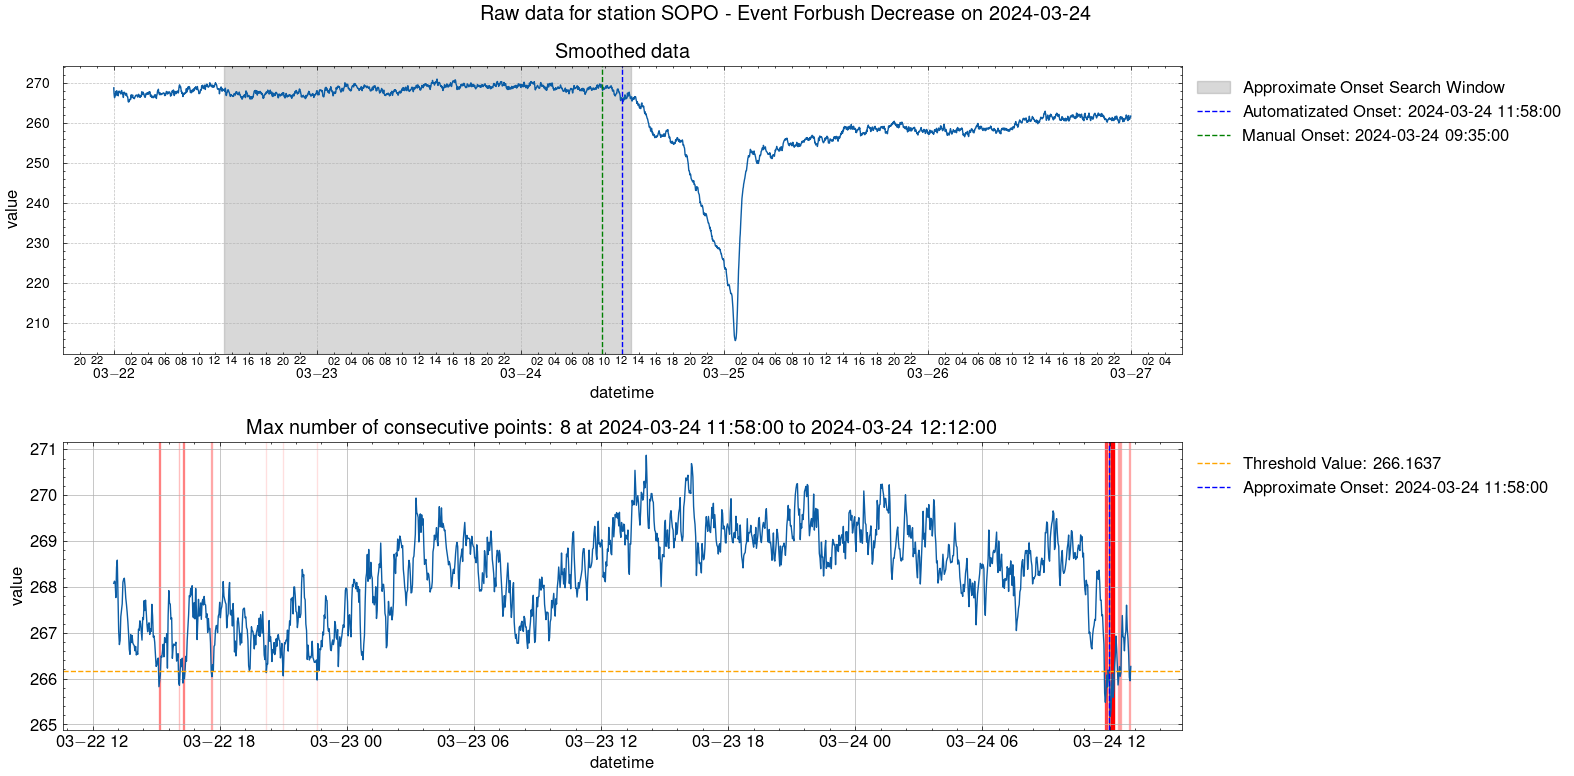

In [19]:
STATION = "SOPO"  # Just one station for testing
real_onset = datetimes[EVENT_DATE]["stations"][STATION][0]

if STATION not in valid_stations:
    raise ValueError(f"Station {STATION} is not valid for event {EVENT}.")

raw_event = raw_df[STATION]
max_onset = "2024-03-24 13:00:00"

values = get_approx_onset(
    raw_event,
    max_onset,
    delta_minutes=60 * 24 * 2,  # 2 days
    debug=True,
    return_filtered_groups=False,
)

(
    onset,
    tmp_df,
    threshold_value,
    groups,
    min_approx_onset_datetime,
    max_approx_onset_datetime,
) = values


plot_onset_analysis(
    raw_event,
    tmp_df,
    threshold_value,
    groups,
    onset,
    real_onset,
    min_approx_onset_datetime,
    max_approx_onset_datetime,
    station=STATION,
)

### NEWK

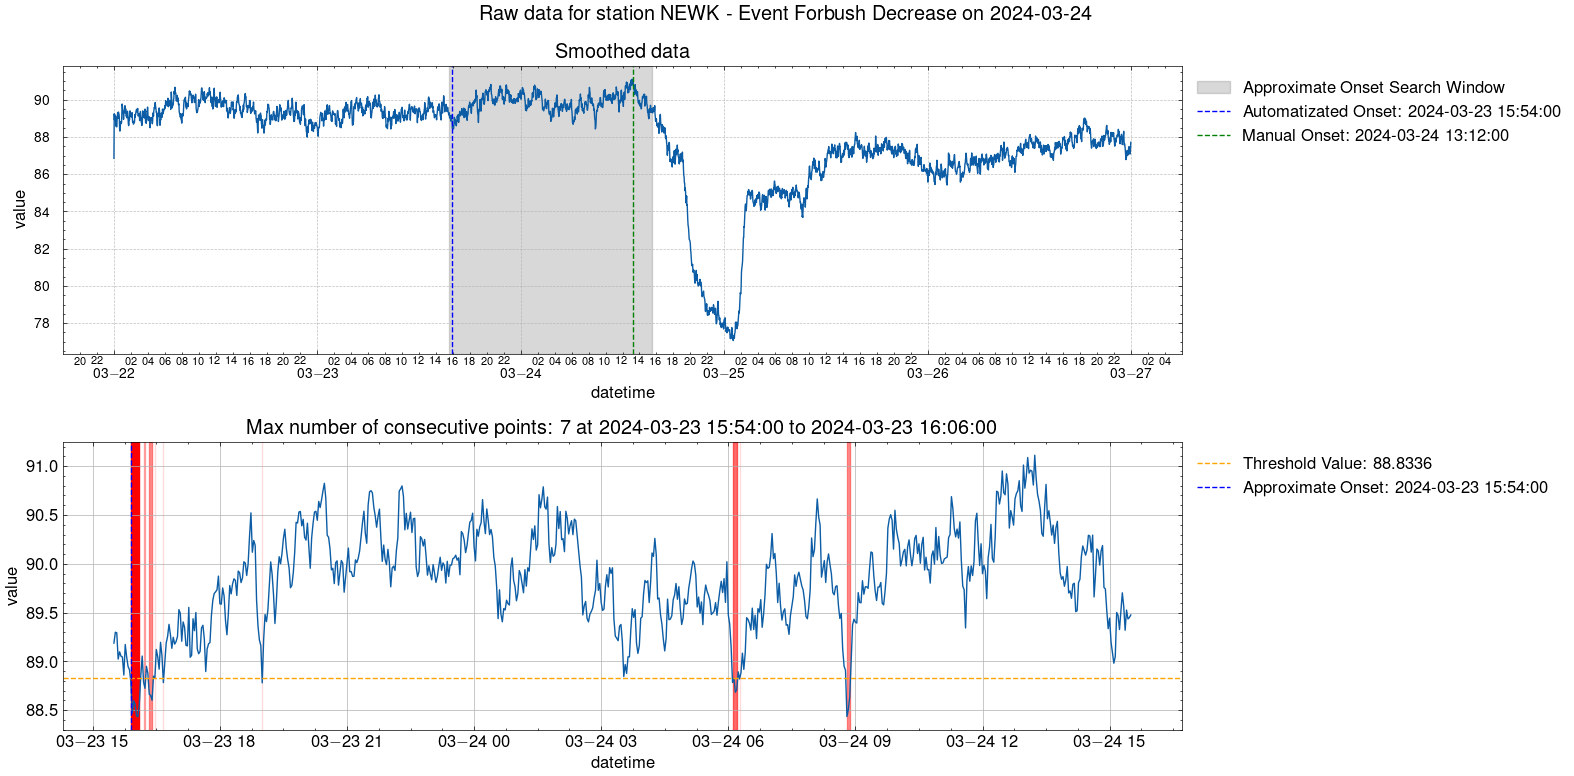

In [20]:
STATION = "NEWK"  # Just one station for testing
real_onset = datetimes[EVENT_DATE]["stations"][STATION][0]

if STATION not in valid_stations:
    raise ValueError(f"Station {STATION} is not valid for event {EVENT}.")

raw_event = raw_df[STATION]
max_onset = "2024-03-24 15:30:00"

values = get_approx_onset(
    raw_event,
    max_onset,
    delta_minutes=60 * 24,
    debug=True,
    return_filtered_groups=False,
)

(
    onset,
    tmp_df,
    threshold_value,
    groups,
    min_approx_onset_datetime,
    max_approx_onset_datetime,
) = values

plot_onset_analysis(
    raw_event,
    tmp_df,
    threshold_value,
    groups,
    onset,
    real_onset,
    min_approx_onset_datetime,
    max_approx_onset_datetime,
    station=STATION,
)

## Multiple stations at the same time